In [55]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [56]:
def create_new_features(df):
    # Timing features
    # df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    # df['hour'] = df['Timestamp'].dt.hour
    # df['minute'] = df['Timestamp'].dt.minute
    # df['day_of_week'] = df['Timestamp'].dt.dayofweek
    # df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # IP-based features
    def ip_to_int(ip):
        try:
            parts = [int(part) for part in ip.split('.')]
            return parts[0] * 256**3 + parts[1] * 256**2 + parts[2] * 256 + parts[3]
        except:
            return 0
    
    non_numeric_cols = ['Protocol']
    for col in non_numeric_cols:
        combined_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str).unique()
        train_df[col] = pd.Categorical(train_df[col], categories=combined_values).codes
        test_df[col] = pd.Categorical(test_df[col], categories=combined_values).codes
    
    # df['Source_IP_num'] = df['Source_IP'].apply(ip_to_int)
    # df['Destination_IP_num'] = df['Destination_IP'].apply(ip_to_int)
    
    # Packet statistics
    df['packets_ratio'] = df['fwd_packets_amount'] / (df['bwd_packets_amount'] + 1)
    df['bytes_ratio'] = df['fwd_packets_length'] / (df['bwd_packets_length'] + 1)
    df['total_packets'] = df['fwd_packets_amount'] + df['bwd_packets_amount']
    df['total_bytes'] = df['fwd_packets_length'] + df['bwd_packets_length']
    df['avg_fwd_packet_size'] = df['fwd_packets_length'] / (df['fwd_packets_amount'] + 1)
    df['avg_bwd_packet_size'] = df['bwd_packets_length'] / (df['bwd_packets_amount'] + 1)
    
    # Flag combinations
    df['total_flags'] = df['FIN_count'] + df['SYN_count'] + df['RST_count'] + df['PSH_count']
    
    # Inter-arrival time statistics
    df['fwd_iat_mean'] = df['mean_fwd_inter_arrival_time']
    df['bwd_iat_mean'] = df['mean_bwd_inter_arrival_time']
    df['iat_ratio'] = df['fwd_iat_mean'] / (df['bwd_iat_mean'] + 1)
    
    # Packet size patterns
    packet_size_cols = [col for col in df.columns if col.startswith('first_packet_sizes_')]
    df['mean_first_packet_size'] = df[packet_size_cols].mean(axis=1)
    df['std_first_packet_size'] = df[packet_size_cols].std(axis=1)
    df['max_first_packet_size'] = df[packet_size_cols].max(axis=1)
    df['min_first_packet_size'] = df[packet_size_cols].min(axis=1)
    
    # Bandwidth features
    bandwidth_cols = [col for col in df.columns if col.startswith('bandwidth_')]
    df['mean_bandwidth'] = df[bandwidth_cols].mean(axis=1)
    df['std_bandwidth'] = df[bandwidth_cols].std(axis=1)
    df['max_bandwidth'] = df[bandwidth_cols].max(axis=1)
    # df['bandwidth_sum'] = df[bandwidth_cols].sum(axis=1)  # New column for bandwidth sum
    
    return df

In [57]:
print("Loading datasets...")
train_df = pd.read_csv(r"C:\Users\חנן\Desktop\אריאל אונ'\שנה ג\זיהוי התקפות\תרגיל\תרגיל\APP-1\Train.csv")
test_df = pd.read_csv(r"C:\Users\חנן\Desktop\אריאל אונ'\שנה ג\זיהוי התקפות\תרגיל\תרגיל\APP-1\Test.csv")

Loading datasets...


In [58]:
# train_df

In [59]:
# Separate features and target
target_column = train_df['label']  # Assuming 'label' is the last column

train_df_processed = create_new_features(train_df)
test_df_processed = create_new_features(test_df)

X = train_df_processed.drop(columns=['label'])  # X = all columns except the last. This is our features
y = train_df_processed['label']  # y = last column. This is our target.

In [60]:
# # Separate features and target
# target_column = train_df.columns[-1]  # Assuming 'label' is the last column

# X = train_df.drop(columns=[target_column])  # X = all columns except the last. This is our features
# y = train_df[target_column]  # y = last column. This is our target.

In [61]:
categorical_columns = X.select_dtypes(include=['object']).columns  # Select object type columns
print(f"Found {len(categorical_columns)} categorical columns: {list(categorical_columns)}")


Found 2 categorical columns: ['Source_IP', 'Destination_IP']


In [62]:
# Initialize label encoders dictionary
label_encoders = {}

# Encode categorical columns
for col in categorical_columns:
    print(f"\nEncoding column: {col}")
    print(f"Original unique values: {X[col].nunique()}")
    
    le = LabelEncoder()
    # Combine train and test data for encoding
    combined_data = pd.concat([X[col], test_df[col]])
    le.fit(combined_data.astype(str))
    
    # Transform both training and test data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded unique values: {len(le.classes_)}")



Encoding column: Source_IP
Original unique values: 8
Encoded unique values: 9

Encoding column: Destination_IP
Original unique values: 330
Encoded unique values: 468


In [63]:
# Let's handle the encoding more carefully
categorical_columns = []
for column in X.columns:
    # Check if column contains any non-numeric values
    if not pd.to_numeric(X[column], errors='coerce').notnull().all() or \
       not pd.to_numeric(test_df[column], errors='coerce').notnull().all():
        categorical_columns.append(column)

print("\nIdentified categorical columns:", categorical_columns)



Identified categorical columns: []


In [64]:
# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    print(f"\nProcessing column: {col}")
    le = LabelEncoder()
    # Combine unique values from both train and test
    combined_values = pd.concat([X[col], test_df[col]]).unique()
    le.fit(combined_values.astype(str))
    
    # Transform the data
    X[col] = le.transform(X[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")


In [65]:
# Now try converting to float again
try:
    X = X.astype(float)
    print("\nSuccessfully converted training data to float")
except ValueError as e:
    print("\nError in converting training data:", e)
    
try:
    test_df = test_df.astype(float)
    print("Successfully converted test data to float")
except ValueError as e:
    print("\nError in converting test data:", e)



Successfully converted training data to float

Error in converting test data: could not convert string to float: '1inch.io'


In [66]:
# Verify final data types
print("\nFinal data types - Training:")
print(X.dtypes.value_counts())
print("\nFinal data types - Test:")
print(test_df.dtypes.value_counts())

# Additional verification step
print("\nVerifying no remaining string values:")
for column in X.columns:
    try:
        X[column].astype(float)
        test_df[column].astype(float)
    except ValueError:
        print(f"Column {column} still contains non-numeric values")



Final data types - Training:
float64    128
Name: count, dtype: int64

Final data types - Test:
int64      98
float64    27
int32       2
int8        1
object      1
Name: count, dtype: int64

Verifying no remaining string values:


In [67]:
first_selection_threshold = 0.97
second_selection_lower_threshold = 0.85
second_selection_upper_threshold = 0.98
## First selection: Features with same value in 97% or more of the data
def find_constant_features(df, threshold=0.97):
    constant_features = []
    for column in df.columns:
        # Calculate the proportion of the most frequent value
        most_frequent_prop = df[column].value_counts(normalize=True).iloc[0]
        if most_frequent_prop >= threshold:
            constant_features.append(column)
    
    return constant_features

# Second selection: Check distribution of features with same value in 85-97% of data
def analyze_near_constant_features(df, y, lower_threshold=0.85, upper_threshold=0.98):
    features_to_remove = []
    total_classes = len(np.unique(y))
    
    print(f"Total number of classes in dataset: {total_classes}")
    
    # Expected uniform distribution probability
    uniform_prob = 1.0 / total_classes
    # Allow some deviation from uniform (e.g., 2x the uniform probability)
    max_allowed_prob = uniform_prob * 2
    
    for column in df.columns:
        # Get value counts and proportions
        value_counts = df[column].value_counts(normalize=True)
        most_frequent_prop = value_counts.iloc[0]
        most_frequent_value = value_counts.index[0]
        
        # If feature has same value in 85-97% of data
        if lower_threshold <= most_frequent_prop < upper_threshold:
            # Get the minority cases (where value is different from most frequent)
            minority_mask = df[column] != most_frequent_value
            minority_labels = y[minority_mask]
            
            # Check distribution of classes in minority cases
            class_distribution = minority_labels.value_counts(normalize=True)
            
            print(f"\nAnalyzing feature: {column}")
            print(f"Most frequent value appears in {most_frequent_prop:.2%} of data")
            print("Class distribution in minority cases:")
            print(class_distribution)
            
            # Analyze distribution
            if len(class_distribution) > 1:  # Only if there are multiple classes
                max_class_prop = class_distribution.max()
                
                # Calculate entropy of distribution
                entropy = -sum(p * np.log2(p) for p in class_distribution)
                max_entropy = -np.log2(1/total_classes)  # Maximum possible entropy
                entropy_ratio = entropy / max_entropy
                
                print(f"Entropy ratio: {entropy_ratio:.2f} (1.0 would be perfectly uniform)")
                
                # Decision criteria:
                # 1. If any class is heavily overrepresented
                # 2. Or if distribution is close to uniform
                if max_class_prop < max_allowed_prob or entropy_ratio > 0.8:
                    features_to_remove.append(column)
                    print("REMOVED: Distribution is too uniform or lacks clear class separation")
                else:
                    print("KEPT: Shows significant class separation")
            else:
                print("KEPT: Only one class in minority cases (strong predictor)")
                
    return features_to_remove

# Apply the feature selection
print("Starting feature selection...")
print(f"Number of unique classes in dataset: {len(np.unique(y))}")


Starting feature selection...
Number of unique classes in dataset: 128


In [68]:
# First stage: Remove highly constant features
constant_features = find_constant_features(X, first_selection_threshold)
print(f"\nFound {len(constant_features)} features with {first_selection_threshold}% constant values:")
for feat in constant_features:
    value_counts = X[feat].value_counts(normalize=True)
    print(f"{feat}: Most common value appears in {value_counts.iloc[0]:.2%} of cases")



Found 31 features with 0.97% constant values:
Destination_port: Most common value appears in 98.91% of cases
Protocol: Most common value appears in 100.00% of cases
bandwidth_0: Most common value appears in 98.28% of cases
bandwidth_4: Most common value appears in 97.34% of cases
bandwidth_6: Most common value appears in 99.06% of cases
bandwidth_8: Most common value appears in 99.84% of cases
bandwidth_10: Most common value appears in 99.69% of cases
bandwidth_12: Most common value appears in 100.00% of cases
bandwidth_14: Most common value appears in 99.84% of cases
bandwidth_16: Most common value appears in 100.00% of cases
bandwidth_18: Most common value appears in 100.00% of cases
bandwidth_19: Most common value appears in 97.03% of cases
beaconning_1: Most common value appears in 97.97% of cases
beaconning_2: Most common value appears in 99.06% of cases
beaconning_3: Most common value appears in 99.53% of cases
beaconning_4: Most common value appears in 99.69% of cases
beaconnin

In [69]:
# Remove these features
X = X.drop(columns=constant_features)
test_df = test_df.drop(columns=constant_features)

In [70]:
# Second stage: Analyze near-constant features
features_to_remove = analyze_near_constant_features(X, y, second_selection_lower_threshold, second_selection_upper_threshold)
print(f"\nFound {len(features_to_remove)} near-constant features to remove:")
for feat in features_to_remove:
    print(f"\n{feat}:")
    value_counts = X[feat].value_counts(normalize=True)
    print(f"Value distribution: {value_counts.head()}")


Total number of classes in dataset: 128

Analyzing feature: min_fwd_packet
Most frequent value appears in 93.59% of data
Class distribution in minority cases:
label
doi.org               0.121951
gizmodo               0.097561
googleadservices      0.097561
google                0.097561
frax.finance          0.097561
facebook              0.048780
iq.wiki               0.048780
walla                 0.048780
bloomberg             0.048780
YouTube               0.048780
drip                  0.024390
discord               0.024390
20thcenturystudios    0.024390
arstechnica           0.024390
jpost                 0.024390
nationalgeographic    0.024390
odysee                0.024390
tomshardware          0.024390
twitch                0.024390
1inch.io              0.024390
Name: proportion, dtype: float64
Entropy ratio: 0.58 (1.0 would be perfectly uniform)
KEPT: Shows significant class separation

Analyzing feature: min_bwd_packet
Most frequent value appears in 92.97% of data
Class d

In [71]:
# Remove these features
X = X.drop(columns=features_to_remove)
test_df = test_df.drop(columns=features_to_remove)

print("\nFeature selection completed.")
print(f"Number of features after selection: {X.shape[1]}")
print("\nRemoved features summary:")
print(f"- {len(constant_features)} highly constant features {first_selection_threshold}")
print(f"- {len(features_to_remove)} near-constant features with uniform class distribution")



Feature selection completed.
Number of features after selection: 97

Removed features summary:
- 31 highly constant features 0.97
- 0 near-constant features with uniform class distribution


In [72]:
# %%
def calculate_vif(X):
    """
    Calculate VIF for each feature
    Returns DataFrame with VIF scores
    """
    vif_data = pd.DataFrame()
    X_with_constant = add_constant(X)
    vif_data["Feature"] = X_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) 
                       for i in range(X_with_constant.shape[1])]
    #print(vif_data)
    print("\nVIF scores:")
    print(vif_data)    

    # Remove the constant term's VIF
    return vif_data[vif_data['Feature'] != 'const'].sort_values('VIF', ascending=False)


In [73]:
def get_correlation_matrix(X):
    """
    Calculate correlation matrix and return it along with a visualization
    """
    correlation_matrix = X.corr()
    
    # Plot correlation heatmap
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    # plt.title('Feature Correlation Heatmap')
    # plt.tight_layout()
    # plt.show()
    
    return correlation_matrix

def identify_correlated_features(correlation_matrix, threshold=0.95):
    """
    Find highly correlated feature pairs
    """
    highly_correlated = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                highly_correlated.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    return highly_correlated


In [74]:
print("Starting multicollinearity analysis...")

# Initial VIF calculation
vif_data = calculate_vif(X)


Starting multicollinearity analysis...


C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
93  max_first_packet_size  9.762340e+00
94  min_first_packet_size  6.003204e+00
95         mean_bandwidth  1.483008e+04
96          std_bandwidth  3.878578e+03
97          max_bandwidth           inf

[98 rows x 2 columns]


In [75]:
correlation_matrix = get_correlation_matrix(X)

# Iterative feature removal process
features_to_remove = set()
vif_threshold = 5
correlation_threshold = 0.95

while True:
    # Get features with high VIF
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['Feature'].tolist()
    
    if not high_vif_features:
        break
    
    # Find highly correlated pairs among high VIF features
    high_vif_correlation = identify_correlated_features(
        correlation_matrix.loc[high_vif_features, high_vif_features],
        correlation_threshold
    )
    
    if not high_vif_correlation:
        # If no high correlations, remove the feature with highest VIF
        worst_feature = vif_data.iloc[0]['Feature']
        features_to_remove.add(worst_feature)
        # print(f"\nRemoving feature with highest VIF: {worst_feature} (VIF: {vif_data.iloc[0]['VIF']:.2f})")
    else:
        # Among correlated pairs, find the one with highest VIF
        for f1, f2, corr in high_vif_correlation:
            print(f"{f1} - {f2}: correlation = {corr:.2f}")
            
        vif_dict = dict(zip(vif_data['Feature'], vif_data['VIF']))
        worst_feature = max(
            high_vif_features,
            key=lambda x: vif_dict.get(x, 0)
        )
        features_to_remove.add(worst_feature)
    
    # Remove selected feature and recalculate VIF
    X = X.drop(columns=[worst_feature])
    test_df = test_df.drop(columns=[worst_feature])
    vif_data = calculate_vif(X)
    correlation_matrix = X.corr()

bandwidth_1 - max_bandwidth: correlation = 1.00
bandwidth_1 - std_bandwidth: correlation = 1.00
total_packets - total_bytes: correlation = 0.98
total_packets - bwd_packets_length: correlation = 0.97
total_packets - bwd_packets_amount: correlation = 0.99
total_packets - ACK_count: correlation = 0.98
total_bytes - bwd_packets_length: correlation = 0.99
total_bytes - bwd_packets_amount: correlation = 0.97
total_bytes - ACK_count: correlation = 1.00
total_flags - PSH_count: correlation = 1.00
bwd_iat_mean - mean_bwd_inter_arrival_time: correlation = 1.00
max_bandwidth - std_bandwidth: correlation = 1.00
fwd_packets_length - fwd_packets_amount: correlation = 0.97
bwd_packets_length - bwd_packets_amount: correlation = 0.98
bwd_packets_length - ACK_count: correlation = 0.99
bwd_packets_amount - ACK_count: correlation = 0.97
mean_fwd_inter_arrival_time - fwd_iat_mean: correlation = 1.00
bandwidth_9 - bandwidth_11: correlation = 1.00
bandwidth_9 - bandwidth_7: correlation = 1.00
bandwidth_11 - 

C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
92  max_first_packet_size  9.762340e+00
93  min_first_packet_size  6.003204e+00
94         mean_bandwidth  1.483008e+04
95          std_bandwidth  3.878578e+03
96          max_bandwidth           inf

[97 rows x 2 columns]
max_bandwidth - bandwidth_1: correlation = 1.00
max_bandwidth - std_bandwidth: correlation = 1.00
bwd_iat_mean - mean_bwd_inter_arrival_time: correlation = 1.00
total_flags - PSH_count: correlation = 1.00
fwd_packets_amount - fwd_packets_length: correlation = 0.97
bwd_packets_amount - bwd_packets_length: correlation = 0.98
bwd_packets_amount - total_packets: correlation = 0.99
bwd_packets_amount - total_bytes: correlation = 0.97
bwd_packets_amount - ACK_count: correlation = 0.97


C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
91  std_first_packet_size  1.201215e+01
92  max_first_packet_size  9.762340e+00
93  min_first_packet_size  6.003204e+00
94         mean_bandwidth  1.483008e+04
95          std_bandwidth  3.878578e+03

[96 rows x 2 columns]
total_bytes - bwd_packets_length: correlation = 0.99
total_bytes - total_packets: correlation = 0.98
total_bytes - bwd_packets_amount: correlation = 0.97
total_bytes - ACK_count: correlation = 1.00
bwd_packets_length - total_packets: correlation = 0.97
bwd_packets_length - bwd_packets_amount: correlation = 0.98
bwd_packets_length - ACK_count: correlation = 0.99
fwd_iat_mean - mean_fwd_inter_arrival_time: correlation = 1.00
PSH_count - total_flags: correlation = 1.00
total_packets

C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
90  std_first_packet_size  1.201215e+01
91  max_first_packet_size  9.762340e+00
92  min_first_packet_size  6.003204e+00
93         mean_bandwidth  1.483008e+04
94          std_bandwidth  3.878578e+03

[95 rows x 2 columns]
fwd_iat_mean - mean_fwd_inter_arrival_time: correlation = 1.00
fwd_packets_amount - fwd_packets_length: correlation = 0.97
bwd_packets_amount - total_packets: correlation = 0.99
bwd_packets_amount - ACK_count: correlation = 0.97
bwd_packets_amount - bwd_packets_length: correlation = 0.98
bwd_iat_mean - mean_bwd_inter_arrival_time: correlation = 1.00
total_flags - PSH_count: correlation = 1.00
total_packets - ACK_count: correlation = 0.98
total_packets - bwd_packets_length: correl

C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
89  std_first_packet_size  1.201215e+01
90  max_first_packet_size  9.762340e+00
91  min_first_packet_size  6.003204e+00
92         mean_bandwidth  1.483008e+04
93          std_bandwidth  3.878578e+03

[94 rows x 2 columns]
bwd_iat_mean - mean_bwd_inter_arrival_time: correlation = 1.00
fwd_packets_amount - fwd_packets_length: correlation = 0.97
bwd_packets_amount - total_packets: correlation = 0.99
bwd_packets_amount - ACK_count: correlation = 0.97
bwd_packets_amount - bwd_packets_length: correlation = 0.98
PSH_count - total_flags: correlation = 1.00
total_packets - ACK_count: correlation = 0.98
total_packets - bwd_packets_length: correlation = 0.97
bandwidth_1 - std_bandwidth: correlation = 1.00
AC

C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
88  std_first_packet_size  1.201215e+01
89  max_first_packet_size  9.762340e+00
90  min_first_packet_size  6.003204e+00
91         mean_bandwidth  1.483008e+04
92          std_bandwidth  3.878578e+03

[93 rows x 2 columns]
fwd_packets_amount - fwd_packets_length: correlation = 0.97
bwd_packets_amount - total_packets: correlation = 0.99
bwd_packets_amount - ACK_count: correlation = 0.97
bwd_packets_amount - bwd_packets_length: correlation = 0.98
total_packets - ACK_count: correlation = 0.98
total_packets - bwd_packets_length: correlation = 0.97
total_flags - PSH_count: correlation = 1.00
bandwidth_1 - std_bandwidth: correlation = 1.00
ACK_count - bwd_packets_length: correlation = 0.99
bandwidth_9 - 

C:\anconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF scores:
                  Feature           VIF
0                   const  1.412701e+06
1               Source_IP  1.823288e+00
2             Source_port  1.163835e+00
3          Destination_IP  1.329742e+00
4               Timestamp  2.186417e+00
..                    ...           ...
87  std_first_packet_size  1.201215e+01
88  max_first_packet_size  9.762340e+00
89  min_first_packet_size  6.003204e+00
90         mean_bandwidth  1.483008e+04
91          std_bandwidth  3.878578e+03

[92 rows x 2 columns]
PSH_count - total_flags: correlation = 1.00
bandwidth_1 - std_bandwidth: correlation = 1.00
bwd_packets_amount - total_packets: correlation = 0.99
bwd_packets_amount - ACK_count: correlation = 0.97
bwd_packets_amount - bwd_packets_length: correlation = 0.98
total_packets - ACK_count: correlation = 0.98
total_packets - bwd_packets_length: correlation = 0.97
ACK_count - bwd_packets_length: correlation = 0.99
bandwidth_9 - bandwidth_11: correlation = 1.00
bandwidth_9 - bandwidth_7: 

In [76]:
print("\nMulticollinearity analysis completed.")
print(f"Removed {len(features_to_remove)} features due to high multicollinearity:")


Multicollinearity analysis completed.
Removed 34 features due to high multicollinearity:


In [77]:
def perform_chi_square_test(X, y, significance_level=0.05):
    """
    Perform chi-square test on categorical features
    """
    # Find categorical columns (those that were label encoded)
    results = []
    
    print("Performing Chi-square test on categorical features...")
    for column in X.columns:
        # Create contingency table
        contingency_table = pd.crosstab(X[column], y)
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Store results
        results.append({
            'Feature': column,
            'Chi-Square': chi2,
            'P-value': p_value,
            'Degrees of Freedom': dof
        })
    
    # Convert to DataFrame and sort by chi-square value
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Chi-Square', ascending=False)
    
    # Identify significant features
    significant_features = results_df[results_df['P-value'] < significance_level]
    
    # Print results
    print("\nChi-square test results:")
    print(results_df)
    print(f"\nFound {len(significant_features)} significant features at {significance_level} significance level")
    print("\nSignificant features:")
    print(significant_features['Feature'].tolist())
    
    return results_df

# Perform chi-square test
chi_square_results = perform_chi_square_test(X, y)


Performing Chi-square test on categorical features...

Chi-square test results:
                       Feature    Chi-Square       P-value  Degrees of Freedom
3                    Timestamp  81280.000000  3.757255e-01               81153
52                     pps_fwd  81152.000000  3.765733e-01               81026
53                     pps_bwd  80725.333333  3.022705e-01               80518
1                  Source_port  79616.000000  5.909008e-02               78994
44            mean_packet_size  79452.444444  1.737608e-02               78613
..                         ...           ...           ...                 ...
6               min_fwd_packet   2116.431727  2.607194e-45                1270
8               min_bwd_packet   1903.058824  3.176294e-18                1397
9                    SYN_count   1591.952628  1.520966e-09                1270
13  min_bwd_inter_arrival_time   1445.590682  1.784227e-01                1397
10                   RST_count    542.539711  9.591

In [78]:
print("Remaining features after chi-square test:")
print(X.columns.tolist())

Remaining features after chi-square test:
['Source_IP', 'Source_port', 'Destination_IP', 'Timestamp', 'fwd_packets_length', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'SYN_count', 'RST_count', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'max_bwd_inter_arrival_time', 'mean_bwd_inter_arrival_time', 'min_bib_inter_arrival_time', 'first_packet_sizes_0', 'first_packet_sizes_2', 'first_packet_sizes_4', 'first_packet_sizes_5', 'first_packet_sizes_6', 'first_packet_sizes_7', 'first_packet_sizes_8', 'first_packet_sizes_9', 'first_packet_sizes_10', 'first_packet_sizes_11', 'first_packet_sizes_12', 'first_packet_sizes_13', 'first_packet_sizes_14', 'first_packet_sizes_15', 'first_packet_sizes_16', 'first_packet_sizes_17', 'first_packet_sizes_18', 'first_packet_sizes_19', 'first_packet_sizes_20', 'first_packet_sizes_21', 'first_packet_sizes_23', 'first_packet_sizes_24', 'first_packet_sizes_25', 'first_packet_sizes_26', 'fir

In [79]:
# %%
def perform_anova_feature_selection(X, y, significance_level=0.05):
    """
    Perform ANOVA F-test for numeric features
    """
    results = []
    print("Performing ANOVA F-test on numeric features...")
    
    for column in X.columns:
        # Create lists of values for each class
        class_values = [X[column][y == class_label] for class_label in np.unique(y)]
        
        # Perform one-way ANOVA
        f_statistic, p_value = stats.f_oneway(*class_values)
        
        # Calculate effect size (eta-squared)
        # Between-group sum of squares
        grand_mean = np.mean([values.mean() for values in class_values])
        ss_between = sum(len(values) * (values.mean() - grand_mean)**2 for values in class_values)
        
        # Total sum of squares
        all_values = np.concatenate(class_values)
        ss_total = sum((all_values - grand_mean)**2)
        
        # Calculate eta-squared
        eta_squared = ss_between / ss_total if ss_total != 0 else 0
        
        results.append({
            'Feature': column,
            'F-statistic': f_statistic,
            'P-value': p_value,
            'Effect Size (eta²)': eta_squared
        })
    
    # Convert to DataFrame and sort by F-statistic
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('F-statistic', ascending=False)
    
    # Identify significant features with meaningful effect size
    # Using both statistical significance and effect size thresholds
    significant_features = results_df[
        (results_df['P-value'] < significance_level) & 
        (results_df['Effect Size (eta²)'] > 0.01)  # Small effect size threshold
    ]
    
    print("\nANOVA F-test results:")
    print(results_df)
    print(f"\nFound {len(significant_features)} significant features with meaningful effect size")
    print("\nSignificant features with meaningful effect size:")
    print(significant_features['Feature'].tolist())
    
    # Create lists of features to keep and remove
    features_to_keep = significant_features['Feature'].tolist()
    features_to_remove = [col for col in X.columns if col not in features_to_keep]
    
    # Remove non-significant features or those with negligible effect size
    X_selected = X[features_to_keep]
    test_df_selected = test_df[features_to_keep]
    
    print(f"\nRemoved {len(features_to_remove)} features")
    print(f"Remaining features: {X_selected.shape[1]}")
    
    return X_selected, test_df_selected, results_df

# Perform ANOVA feature selection
X_selected, test_df_selected, anova_results = perform_anova_feature_selection(X, y)


Performing ANOVA F-test on numeric features...

ANOVA F-test results:
                       Feature  F-statistic        P-value  Effect Size (eta²)
3                    Timestamp    34.682108  5.916456e-188            0.895864
0                    Source_IP    25.539881  5.409471e-159            0.863669
59                 total_flags    10.320217   1.453931e-83            0.719093
5              max_fwd_packet     10.319443   1.472234e-83            0.719078
2               Destination_IP     6.922803   5.171337e-57            0.631971
..                         ...          ...            ...                 ...
60                   iat_ratio     1.151232   1.478133e-01            0.222129
8               min_bwd_packet     1.015088   4.462861e-01            0.201144
47                 bandwidth_2     1.007586   4.672973e-01            0.199954
52                     pps_fwd     0.995090   5.027458e-01            0.197965
16  min_bib_inter_arrival_time     0.952562   6.241736e-01   

In [80]:
print("Remaining features after ANOVA F-test:")
print(X.columns.tolist())

Remaining features after ANOVA F-test:
['Source_IP', 'Source_port', 'Destination_IP', 'Timestamp', 'fwd_packets_length', 'max_fwd_packet ', 'min_fwd_packet', 'max_bwd_packet', 'min_bwd_packet', 'SYN_count', 'RST_count', 'min_fwd_inter_arrival_time', 'max_fwd_inter_arrival_time', 'min_bwd_inter_arrival_time', 'max_bwd_inter_arrival_time', 'mean_bwd_inter_arrival_time', 'min_bib_inter_arrival_time', 'first_packet_sizes_0', 'first_packet_sizes_2', 'first_packet_sizes_4', 'first_packet_sizes_5', 'first_packet_sizes_6', 'first_packet_sizes_7', 'first_packet_sizes_8', 'first_packet_sizes_9', 'first_packet_sizes_10', 'first_packet_sizes_11', 'first_packet_sizes_12', 'first_packet_sizes_13', 'first_packet_sizes_14', 'first_packet_sizes_15', 'first_packet_sizes_16', 'first_packet_sizes_17', 'first_packet_sizes_18', 'first_packet_sizes_19', 'first_packet_sizes_20', 'first_packet_sizes_21', 'first_packet_sizes_23', 'first_packet_sizes_24', 'first_packet_sizes_25', 'first_packet_sizes_26', 'first_

In [81]:
y_test = test_df['label']

# Remove 'label' column from test data
if 'label' in test_df.columns:
    X_test = test_df.drop(columns=['label'])

# Verify column alignment
missing_cols = set(X.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X.columns)

if missing_cols:
    print(f"\nWarning: Test data is missing columns: {missing_cols}")
if extra_cols:
    print(f"\nWarning: Test data has extra columns: {extra_cols}")

# Ensure columns are in the same order as training data
X_test = test_df[X.columns]


In [82]:
# X_test

In [83]:
from sklearn.metrics import accuracy_score

print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,   # For reproducibility
    n_jobs=-1          # Use all available cores
)

# rf_model.fit(X_train, y_train)
rf_model.fit(X, y)

# Predict on test data
y_pred = rf_model.predict(X_test)

 # Evaluate model
print("\nRandom Forest - Test Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Accuracy
print("\nRandom Forest - Test Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Training Random Forest model...

Random Forest - Test Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 4]]

Random Forest - Test Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.50      0.40      0.44         5
   20thcenturystudios       1.00      0.60      0.75         5
              YouTube       1.00      0.60      0.75         5
        aboutads.info       0.67      0.80      0.73         5
   adventuresbydisney       0.80      0.80      0.80         5
alainelkanninterviews       1.00      1.00      1.00         5
           algemeiner       0.75      0.60      0.67         5
            amazonaws       0.71      1.00      0.83         5
                apple       0.60      0.60      0.60         5
          arstechnica       0.36      0.80      0.50         5
       atlantis-press       1.00      0.80      0.89         5
     

C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Generating feature importance plot...


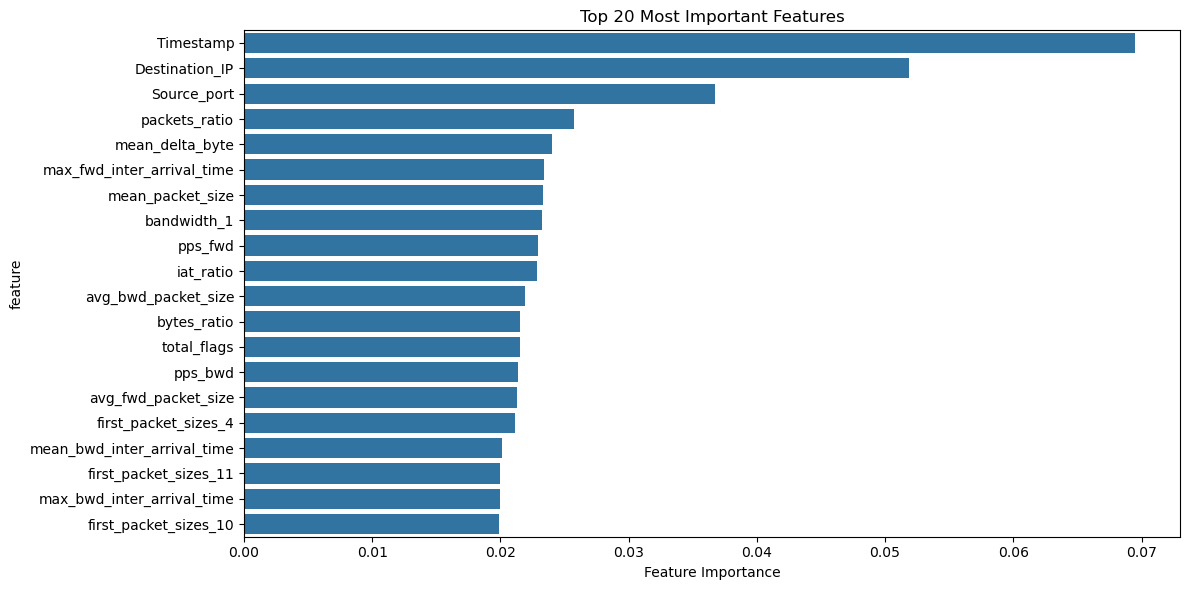

In [84]:
# Feature importance plot
print("\nGenerating feature importance plot...")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


In [97]:
number_of_top_features = 7
top_features = feature_importance.head(number_of_top_features)['feature'].tolist()
print(f"Selected top {number_of_top_features} features:")
for i, feat in enumerate(top_features, 1):
    importance = feature_importance[feature_importance['feature'] == feat]['importance'].iloc[0]
    print(f"{i}. {feat} (importance: {importance:.4f})")


Selected top 7 features:
1. Timestamp (importance: 0.0695)
2. Destination_IP (importance: 0.0519)
3. Source_port (importance: 0.0367)
4. packets_ratio (importance: 0.0257)
5. mean_delta_byte (importance: 0.0240)
6. max_fwd_inter_arrival_time (importance: 0.0234)
7. mean_packet_size (importance: 0.0233)


In [98]:
# Create new datasets with only top features
X_top = X[top_features]
test_df_top = X_test[top_features]


In [99]:
X_top

,Timestamp,Destination_IP,Source_port,packets_ratio,mean_delta_byte,max_fwd_inter_arrival_time,mean_packet_size
0,1.728158e+09,306.0,52264.0,0.352798,336.781195,15.164509,1037.280193
1,1.728158e+09,306.0,52286.0,0.353060,342.527473,15.164509,1134.339416
2,1.727977e+09,177.0,55125.0,0.835225,250.699507,6.609804,652.225490
3,1.728158e+09,306.0,52287.0,0.353323,433.982759,15.164509,1046.841202
4,1.728158e+09,377.0,51187.0,0.500000,334.228571,0.548142,680.000000
...,...,...,...,...,...,...,...
635,1.728162e+09,345.0,56423.0,0.627119,287.583062,0.133076,783.902597
636,1.728161e+09,345.0,55393.0,0.672956,297.571930,0.670242,756.055944
637,1.728161e+09,345.0,55394.0,0.904762,350.666667,0.134311,418.526316
638,1.728161e+09,345.0,55447.0,0.413302,286.526829,1.918182,921.668831


In [100]:
# Check class distribution
class_counts = pd.Series(y).value_counts()

print("\nClass distribution in training set:")
print(class_counts)
min_samples = class_counts.min()
print(f"\nSmallest class has {min_samples} samples")

# Determine appropriate number of folds
n_splits = min(3, min_samples)  # Use minimum between 3 and smallest class size
print(f"Using {n_splits}-fold cross-validation")




Class distribution in training set:
label
1inch.io               5
20thcenturystudios     5
slate                  5
scholarpedia           5
revolut                5
                      ..
doi.org                5
disneystore            5
disneyplus             5
disneymovieinsiders    5
youradchoices          5
Name: count, Length: 128, dtype: int64

Smallest class has 5 samples
Using 3-fold cross-validation


In [101]:
# Initialize and train Bagging Classifier
print("\nTraining Bagging Classifier...")
bag_clf = BaggingClassifier(
    n_estimators=150,
    max_samples=0.8,    
    max_features=0.8,   
    random_state=42,
    n_jobs=-1
)

# Perform cross-validation if possible
if n_splits > 1:
    print(f"\nPerforming {n_splits}-fold cross-validation...")
    try:
        # cv_scores = cross_val_score(bag_clf, X_train_top, y_train, cv=n_splits)
        cv_scores = cross_val_score(bag_clf, X_top, y, cv=n_splits)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except ValueError as e:
        print(f"Could not perform cross-validation: {e}")
else:
    print("\nNot enough samples for cross-validation")



Training Bagging Classifier...

Performing 3-fold cross-validation...
Cross-validation scores: [0.71962617 0.71361502 0.66666667]
Average CV score: 0.7000 (+/- 0.0474)


In [102]:
bag_clf.fit(X_top, y)

# Make predictions on test set
test_predictions = bag_clf.predict(test_df_top)

# Make predictions with both models on test data
print("\nComparing Random Forest and Bagging Classifier on test data...")

# Random Forest predictions
rf_test_predictions = rf_model.predict(X_test)
print("\nRandom Forest Performance on Test Set:")
print("\nClassification Report:")
print(classification_report(y_test, rf_test_predictions))
rf_accuracy = accuracy_score(y_test, rf_test_predictions)

# Bagging Classifier predictions
bag_test_predictions = bag_clf.predict(test_df_top)
print("\nBagging Classifier Performance on Test Set:")
print("\nClassification Report:")
print(classification_report(y_test, bag_test_predictions))
bag_accuracy = accuracy_score(y_test, bag_test_predictions)

# Compare accuracies
print("\nModel Comparison on Test Set:")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Difference: {abs(rf_accuracy - bag_accuracy):.4f}")



Comparing Random Forest and Bagging Classifier on test data...

Random Forest Performance on Test Set:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.50      0.40      0.44         5
   20thcenturystudios       1.00      0.60      0.75         5
              YouTube       1.00      0.60      0.75         5
        aboutads.info       0.67      0.80      0.73         5
   adventuresbydisney       0.80      0.80      0.80         5
alainelkanninterviews       1.00      1.00      1.00         5
           algemeiner       0.75      0.60      0.67         5
            amazonaws       0.71      1.00      0.83         5
                apple       0.60      0.60      0.60         5
          arstechnica       0.36      0.80      0.50         5
       atlantis-press       1.00      0.80      0.89         5
                axios       0.33      0.60      0.43         5
                  bbc       0.60      0.60      0.60

C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Bagging Classifier Performance on Test Set:

Classification Report:
                       precision    recall  f1-score   support

             1inch.io       0.60      0.60      0.60         5
   20thcenturystudios       1.00      0.60      0.75         5
              YouTube       1.00      0.60      0.75         5
        aboutads.info       1.00      1.00      1.00         5
   adventuresbydisney       0.56      1.00      0.71         5
alainelkanninterviews       1.00      1.00      1.00         5
           algemeiner       1.00      1.00      1.00         5
            amazonaws       1.00      1.00      1.00         5
                apple       1.00      0.80      0.89         5
          arstechnica       0.62      1.00      0.77         5
       atlantis-press       1.00      0.80      0.89         5
                axios       0.60      0.60      0.60         5
                  bbc       1.00      0.80      0.89         5
              binance       0.62      1.00      

In [42]:
# # Create label encoder for target variable
# le_target = LabelEncoder()
# y_encoded = le_target.fit_transform(y)
# test_labels_encoded = le_target.transform(y_test)

# # XGBoost
# print("\nTraining XGBoost model...")
# xgb_model = XGBClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     max_depth=7,
#     random_state=42,
#     n_jobs=-1
# )
# xgb_model.fit(X_top, y_encoded)

# # LightGBM
# print("\nTraining LightGBM model...")
# lgb_model = LGBMClassifier(
#     n_estimators=100,
#     learning_rate=0.1,
#     num_leaves=31,
#     random_state=42,
#     n_jobs=-1
# )
# lgb_model.fit(X_top, y_encoded)

# # CatBoost
# print("\nTraining CatBoost model...")
# cat_model = CatBoostClassifier(
#     iterations=100,
#     learning_rate=0.1,
#     depth=7,
#     random_seed=42,
#     verbose=False
# )
# cat_model.fit(X_top, y_encoded)

# # Voting Classifier
# print("\nTraining Voting Classifier...")
# voting_clf = VotingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
#         ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
#         ('lgb', LGBMClassifier(n_estimators=100, random_state=42))
#     ],
#     voting='soft'
# )
# voting_clf.fit(X_top, y_encoded)

# # Stacking Classifier
# print("\nTraining Stacking Classifier...")
# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
#     ('xgb', XGBClassifier(n_estimators=100, random_state=42)),
#     ('lgb', LGBMClassifier(n_estimators=100, random_state=42))
# ]
# stack_clf = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     cv=3
# )
# stack_clf.fit(X_top, y_encoded)

# # Make predictions and convert back to original labels
# # XGBoost
# xgb_test_predictions = le_target.inverse_transform(xgb_model.predict(test_df_top))
# xgb_accuracy = accuracy_score(y_test, xgb_test_predictions)
# print("\nXGBoost Performance:")
# print(classification_report(y_test, xgb_test_predictions))

# # LightGBM
# lgb_test_predictions = le_target.inverse_transform(lgb_model.predict(test_df_top))
# lgb_accuracy = accuracy_score(y_test, lgb_test_predictions)
# print("\nLightGBM Performance:")
# print(classification_report(y_test, lgb_test_predictions))

# # CatBoost
# cat_test_predictions = le_target.inverse_transform(cat_model.predict(test_df_top))
# cat_accuracy = accuracy_score(y_test, cat_test_predictions)
# print("\nCatBoost Performance:")
# print(classification_report(y_test, cat_test_predictions))

# # Voting Classifier
# voting_test_predictions = le_target.inverse_transform(voting_clf.predict(test_df_top))
# voting_accuracy = accuracy_score(y_test, voting_test_predictions)
# print("\nVoting Classifier Performance:")
# print(classification_report(y_test, voting_test_predictions))

# # Stacking Classifier
# stack_test_predictions = le_target.inverse_transform(stack_clf.predict(test_df_top))
# stack_accuracy = accuracy_score(y_test, stack_test_predictions)
# print("\nStacking Classifier Performance:")
# print(classification_report(y_test, stack_test_predictions))

# # Final comparison
# print("\nFinal Model Comparison (Test Set Accuracy):")
# print(f"Random Forest:       {rf_accuracy:.4f}")
# print(f"Bagging Classifier:  {bag_accuracy:.4f}")
# print(f"XGBoost:            {xgb_accuracy:.4f}")
# print(f"LightGBM:           {lgb_accuracy:.4f}")
# print(f"CatBoost:           {cat_accuracy:.4f}")
# print(f"Voting Classifier:   {voting_accuracy:.4f}")
# print(f"Stacking Classifier: {stack_accuracy:.4f}")
